# Changes in DOAC prescribing for GIRFT report into pathology

## Change over time

In [3]:
##import libraries needed
import pandas as pd
import os as os
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [7]:
# CCG level data
sql = '''
SELECT 
  DATE(month) AS month, 
  pct, 
  SUM(
    CASE WHEN SUBSTR(bnf_code, 0, 9) IN (
      '0208020Z0', '0208020X0', '0208020AA', '0208020Y0'
    ) THEN items ELSE 0 END
  ) AS doacs, #apixaban, dabigatran etexilate, edoxaban, rivaroxaban
  100* ieee_divide (
    SUM(
      CASE WHEN SUBSTR(bnf_code, 0, 9) IN (
        '0208020Z0', '0208020X0', '0208020AA', '0208020Y0'
      ) THEN items ELSE 0 END
    ), 
    SUM(items)
  ) AS perc_doacs 
FROM 
  hscic.normalised_prescribing AS rx 
  INNER JOIN hscic.ccgs AS ccg ON rx.pct = ccg.code 
WHERE 
  SUBSTR(bnf_code, 0, 9) IN (
    '0208020Z0', '0208020X0', '0208020AA', '0208020Y0', '0208020V0'
  ) #apixaban, dabigatran etexilate, edoxaban, rivaroxaban, warfarin
  AND ccg.org_type = 'CCG'
  AND month >='2012-01-01'
GROUP BY 
  month, 
  pct
ORDER BY
  month, 
  pct
'''
df_ccg = bq.cached_read(sql, csv_path=os.path.join('..','data','df_ccg.csv'), cache=True)
df_ccg['month'] = df_ccg['month'].astype('datetime64[ns]')

## Increase in uptake of DOACs nationally

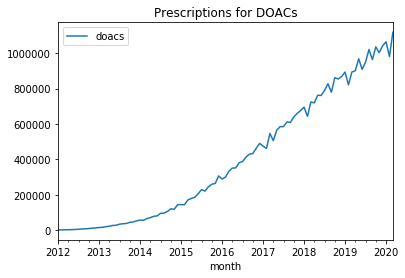

In [8]:
df_ccg_overall = df_ccg.drop(columns=["perc_doacs"])
df_ccg_overall.groupby("month").sum().plot(kind='line', title="Prescriptions for DOACs")

## Map of CCG uptake of DOACs in latest month

In [10]:
#create only latest month's CCG data
latest_date = df_ccg['month'].max()
df_ccg_map = df_ccg.loc[df_ccg['month'] == latest_date]
ld_string = latest_date.month_name() + " " + str(latest_date.year) #this creates string to label chart

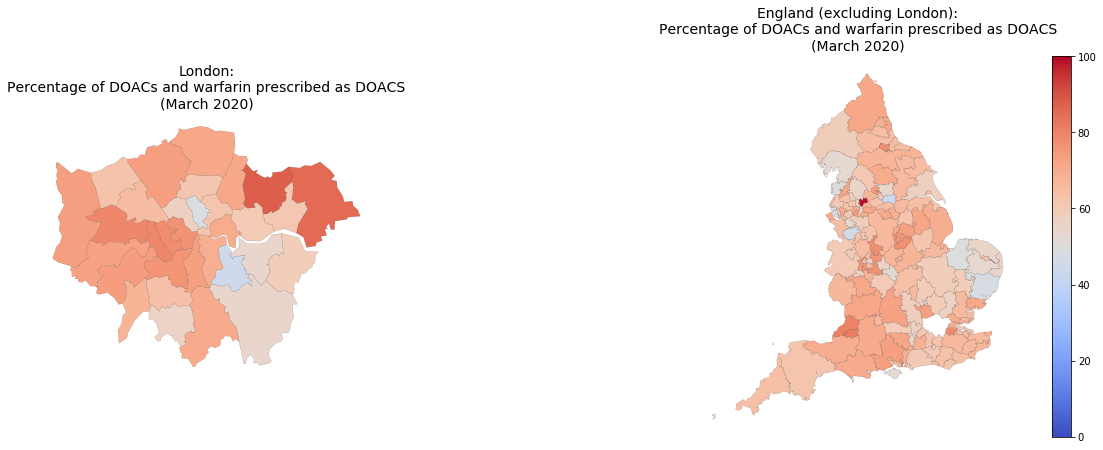

In [11]:
plt.figure(figsize=(20, 7))
maps.ccg_map(
    df_ccg_map,
    title='Percentage of DOACs and warfarin prescribed as DOACS\n(' + ld_string + ')',
    column='perc_doacs', 
    separate_london=True,
    plot_options={'vmax': 100, 'vmin': 0, 'cmap': 'coolwarm'}
    )
plt.show()

## Deciles of CCGs for percentage as DOACs

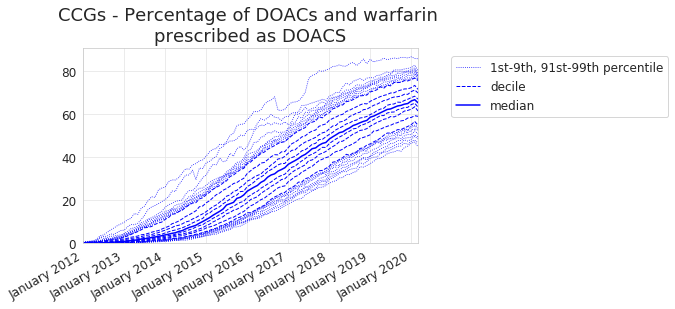

In [12]:
#plot deciles for DOACs
charts.deciles_chart(
        df_ccg,
        period_column='month',
        column= 'perc_doacs',
        title="CCGs - Percentage of DOACs and warfarin \nprescribed as DOACS",
        show_outer_percentiles=True)
plt.show()